# Predicting daily bikerider count from temperature and weekday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
import arviz as az

import scipy.stats as stats

## Import data

We import a dataset that contains the daily number of bike riders at a counting station in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.') in 2021 as well as the daily average temperature and a boolean whether a given day is a business day.

In [2]:
# import data
combined_daily_dat = pd.read_pickle('./../data/processed/combined_daily_dat_FR1.pkl')

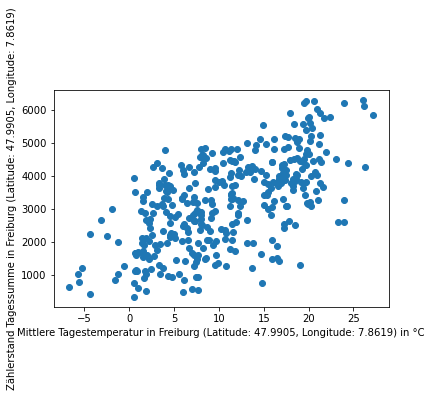

In [3]:
# plot daily bikerider count by mean day temperature
plt.scatter(combined_daily_dat['temperature'], combined_daily_dat['rider_count'])
plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)');

In [4]:
def plot_data():
    # TODO kommentieren
    '''
    Plot daily bikerider count by mean day temperature, separate between business days and weekends.
    '''
    # plot data
    plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == True]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == True]['rider_count'], label='business day', color='orange')
    plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == False]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == False]['rider_count'], label='weekend', color='blue')

    # legend
    # TODO
    #plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
    #plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)')
    plt.xlabel('Average daily temperature [°C]')
    plt.ylabel('Daily number of bike riders')
    plt.legend();

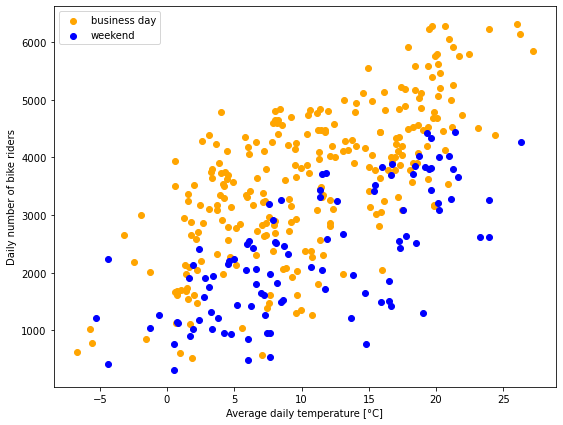

In [5]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.figure(figsize=(9,7))
plot_data()

Define utility functions to plot the data with model fits later on:

In [6]:
def plot_data_and_linear_fit(intercept, slope, intercept_business_days, slope_interaction, is_bayes=False):
    # TODO kommentieren
    
    # adjust labels
    if (is_bayes):
        label_busday_fit = 'busday mean posterior'
        label_non_busday_fit = 'non_busday mean posterior'
    else:
        label_busday_fit = 'busday_fit'
        label_non_busday_fit = 'non_busday_fit'
    
    # plot fit
    x_temps = np.linspace(-5, 25, 10)
    plt.plot(x_temps, intercept +  x_temps * slope, label=label_non_busday_fit, color='blue')
    plt.plot(x_temps, intercept + intercept_business_days +  x_temps * (slope + slope_interaction), label=label_busday_fit, color='orange')
    
    # plot data
    plot_data()

In [7]:
def plot_data_and_exponential_fit(intercept, slope, intercept_business_days, slope_interaction, is_bayes=False):
    # TODO kommentieren
    
    # adjust labels
    if (is_bayes):
        label_busday_fit = 'busday mean posterior'
        label_non_busday_fit = 'non_busday mean posterior'
    else:
        label_busday_fit = 'busday_fit'
        label_non_busday_fit = 'non_busday_fit'
    
    # plot fit
    x_temps = np.linspace(-5, 25, 10)
    plt.plot(x_temps, np.exp(intercept +  x_temps * slope), label=label_non_busday_fit, color='blue')
    plt.plot(x_temps, np.exp(intercept + intercept_business_days +  x_temps * (slope + slope_interaction)), label=label_busday_fit, color='orange')
    
    # plot data
    plot_data()

## Statistical Analysis

### Linear Regression: Gaussian model with identity link function

#### Frequentist

In [8]:
# fit linear Gaussian model to the daily bike rider counts data,
# predictors: mean day temperature and being a business day

fit_daily_counts = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat).fit()

# check the fit result
print(fit_daily_counts.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  365
Model:                            GLM   Df Residuals:                      361
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                      7.8842e+05
Method:                          IRLS   Log-Likelihood:                -2993.8
Date:                Wed, 21 Dec 2022   Deviance:                   2.8462e+08
Time:                        23:37:17   Pearson chi2:                 2.85e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7351
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

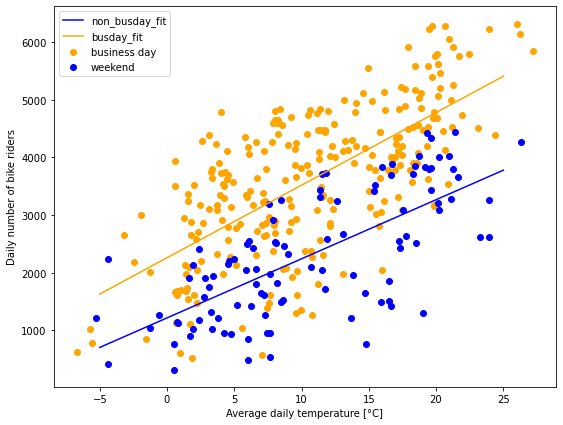

In [9]:
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    fit_daily_counts.params['Intercept'],
    fit_daily_counts.params['temperature'],
    fit_daily_counts.params['is_busday[T.True]'],
    fit_daily_counts.params['temperature:is_busday[T.True]']
)

##### Check some of the model assumptions

Normal distribution of residuals?

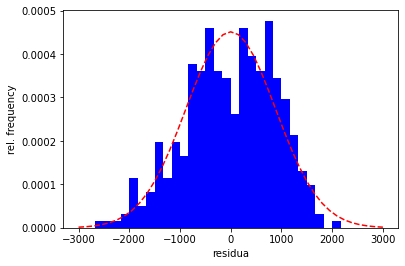

In [10]:
# inspect residuals
bins=np.linspace(-3000., 3000., 37)
x = np.linspace(-3000., 3000., 41)

# plot residuals
plt.hist(fit_daily_counts.resid_response, bins, color='b', density=True)

# estimate Gaussian distribution for residuals
mu, sigma = (fit_daily_counts.resid_response.mean(), fit_daily_counts.resid_response.std())
plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')

# labels
plt.xlabel('residua')
plt.ylabel('rel. frequency');

TODO Schon ein bisschen verschoben, oder? Rechts eher mehr, links eher weniger...
Und links im Rand mehr als rechts.

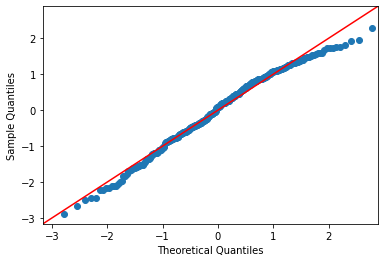

In [11]:
# TODO Stimmt Funktion?
fig = sm.qqplot(fit_daily_counts.resid_response, stats.t, fit=True, line="45")
plt.show()

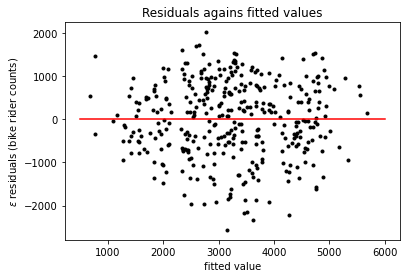

In [12]:
# TODO inspect residuals: residuals vs fits
# equal vairance?
# See also: https://online.stat.psu.edu/stat462/node/117/

plt.plot(fit_daily_counts.predict(combined_daily_dat), fit_daily_counts.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('Residuals agains fitted values');

#### Same same but different: Again, "Linear Regression: Gaussian model with identity link function", Frequentist, but with "smf.ols" to get more summary data

In [13]:
# try different fit method to get more summary data
fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=combined_daily_dat).fit()
print(fit_daily_counts_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            rider_count   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     161.6
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.10e-66
Time:                        23:37:18   Log-Likelihood:                -2993.8
No. Observations:                 365   AIC:                             5996.
Df Residuals:                     361   BIC:                             6011.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

#### Bayes

Utility functions for showing the results:

In [14]:
def show_results(model, plot_fun):
    '''
    Print and plot fit results.
    '''
    # show results
    with model:
        pm.plot_trace(trace)
        display(pm.summary(trace))

    # extract betas
    with model:
        postbetas_intercept = trace["beta_intercept"]
        postbetas_slope = trace["beta_slope"]
        postbetas_intercept_business_days = trace["beta_intercept_business_days"]
        postbetas_slope_interaction = trace["beta_slope_interaction"]
    
    with model:
        ax = az.plot_posterior(trace, var_names=['beta_intercept', 'beta_slope', 'beta_intercept_business_days', 'beta_slope_interaction'])

    
    # plot data and fit
    plt.figure(figsize=(9,7))
    
    # plot data and fit
    plot_fun(postbetas_intercept.mean(),
             postbetas_slope.mean(),
             postbetas_intercept_business_days.mean(),
             postbetas_slope_interaction.mean(),
             True)

In [15]:
def show_results_linear_fit(model):
    '''
    Print and plot fit results for linear fit.
    '''
    show_results(model, plot_data_and_linear_fit)

In [16]:
def show_results_exponential_fit(model):
    '''
    Print and plot fit results for exponential fit.
    '''
    show_results(model, plot_data_and_exponential_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_intercept[0],1219.486,130.772,972.690,1467.702,2.378,1.682,3034.0,3444.0,1.0
beta_slope[0],102.161,10.096,83.586,121.712,0.186,0.132,2963.0,3582.0,1.0
beta_intercept_business_days[0],1032.107,163.286,736.686,1349.015,2.944,2.086,3091.0,3947.0,1.0
beta_slope_interaction[0],24.202,12.776,1.864,50.140,0.235,0.166,2976.0,3824.0,1.0
sigma[0],763.625,51.433,667.703,860.313,0.660,0.471,6218.0,4611.0,1.0
sigma[1],915.922,40.702,839.410,992.162,0.525,0.372,6048.0,4965.0,1.0


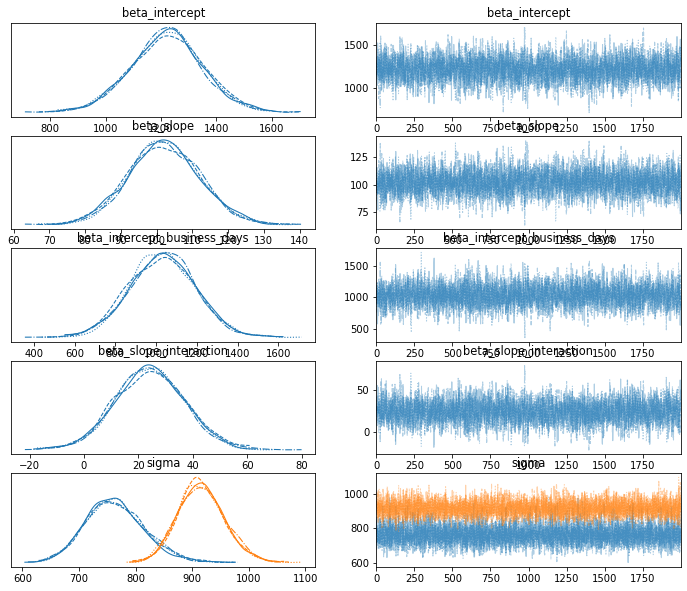

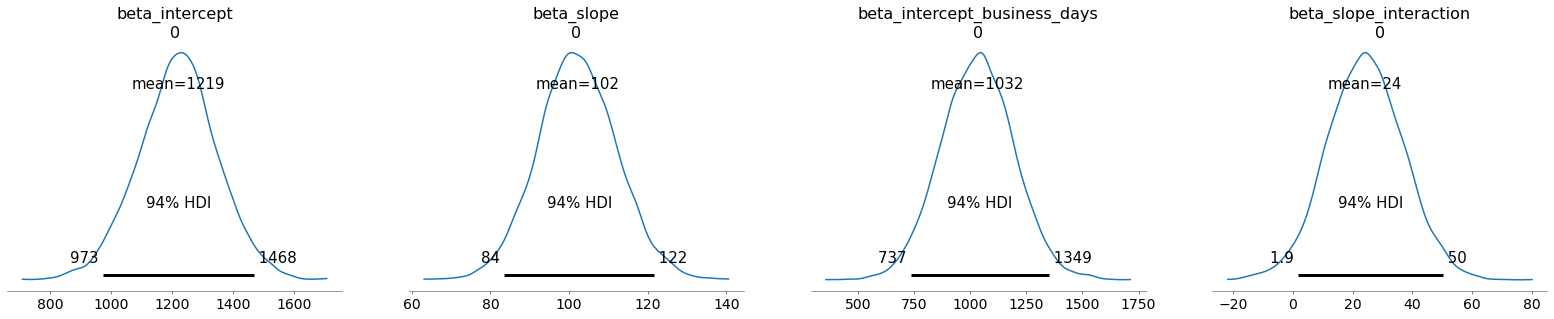

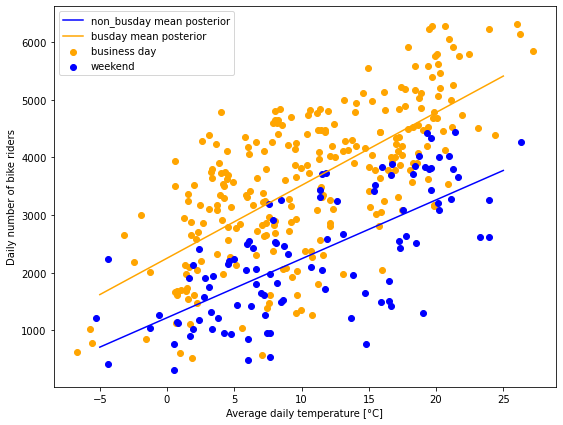

In [17]:
# build linear model with categories "business-day vs no-business-day"

with pm.Model() as linearCategoricalModel:
    
    # TODO prior anpassen
    # prior for parameters beta
    # idea: same parametrization as in Frequentist analysis above.
    # TODO Keep in mind: Prior should reflect prior knowledge; not expectation.
    beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1000, shape=1)
    beta_slope = pm.Normal("beta_slope", mu=0, sigma=100, shape=1)
    beta_intercept_business_days = pm.Normal("beta_intercept_business_days", mu=0, sigma=1000, shape=1)
    beta_slope_interaction = pm.Normal("beta_slope_interaction", mu=0, sigma=100, shape=1)
    
    # prior for two noise distributions: better small
    sigma = pm.Exponential("sigma", lam=.01, shape=2)
    
    # the linear model function
    expected = beta_intercept + beta_slope * combined_daily_dat['temperature'] + beta_intercept_business_days * combined_daily_dat['is_busday'] + beta_slope_interaction * combined_daily_dat['temperature'] * combined_daily_dat['is_busday']
    
    # Data and Likelihood: Gaussian noise
    noise = sigma[0] * (1 - combined_daily_dat['is_busday']) + sigma[1] * combined_daily_dat['is_busday']
    obs = pm.Normal("observed",
                    mu=expected,
                    sigma=noise,
                    observed=combined_daily_dat['rider_count'])

# sample
with linearCategoricalModel:
    trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

# print / plot the fit results
show_results_linear_fit(linearCategoricalModel)

TODO How to check model assumptions? Bayesian residuals?

### Poisson Regression: Poisson model with identity link function

TODO  
Reasonable? Might be that lambda-parameter-value of Poisson distribution is <0...  (--> we assume that this is not an issue for our "region of interest" (i.e., from -5°C to 25°C))  
Poisson-Verteilung der Bike-Rider-Counts? Der Residuen?

#### Frequentist

In [18]:
# fit a poisson model with identity link function to the daily bike rider counts data,
# predictors: mean day temperature and being a business day
fit_daily_counts_poisson_identity = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat,
    family=sm.families.Poisson(link=sm.families.links.identity())).fit()

# check the fit result
print(fit_daily_counts_poisson_identity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  365
Model:                            GLM   Df Residuals:                      361
Model Family:                 Poisson   Df Model:                            3
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52818.
Date:                Wed, 21 Dec 2022   Deviance:                   1.0206e+05
Time:                        23:37:38   Pearson chi2:                 9.52e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/home/maren/anaconda3/envs/angewandte_statistik_bayes_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Warning refers to: The linear relationship might predict negative parameter values for the Poisson distribution ($X \sim \textit{Poisson}(\lambda)$ which is only defined for $\lambda \ge 0$) - however, we assume that in our "region of interest", this is not a problem.

Main difference to the results with normal distribution: Now, the interaction parameter is also significantly different from 0.

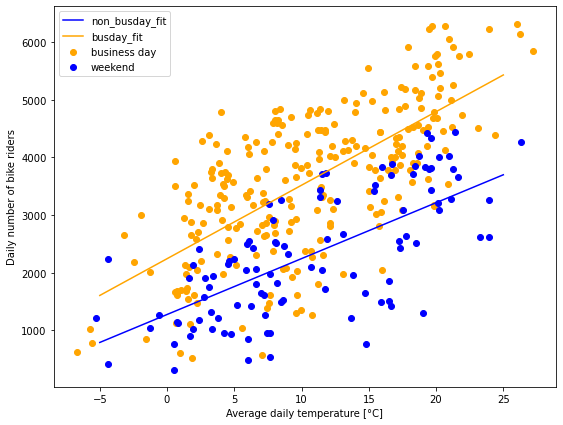

In [19]:
# plot
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    fit_daily_counts_poisson_identity.params['Intercept'],
    fit_daily_counts_poisson_identity.params['temperature'],
    fit_daily_counts_poisson_identity.params['is_busday[T.True]'],
    fit_daily_counts_poisson_identity.params['temperature:is_busday[T.True]']
)

##### Check one of the Poisson model assumptions

https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html, Table 4.2

Poisson distribution: Expected value equals Variance.

business days:
      mean         var  var/mean     n
0   808.33    39890.33     49.35   3.0
1  2140.80   680508.70    317.88   5.0
2  2446.65  1045422.85    427.29  37.0
3  3265.97   595984.47    182.48  37.0
4  3144.25  1261071.47    401.07  48.0
5  3670.32   942811.63    256.87  38.0
6  4028.26   595854.26    147.92  31.0
7  4666.18   696067.92    149.17  44.0
8  5072.77   706304.53    139.23  13.0
9  5783.00   637006.50    110.15   5.0
non-business days:
      mean         var  var/mean     n
0  1294.00   827553.00    639.53   3.0
1  1150.00    23328.00     20.29   2.0
2  1402.44   322280.93    229.80  16.0
3  1705.31   440632.10    258.39  16.0
4  1940.47   645555.14    332.68  17.0
5  2855.60   536878.49    188.01  10.0
6  2325.46  1319592.94    567.45  13.0
7  3335.67   652499.41    195.61  18.0
8  3637.17   401507.37    110.39   6.0
9  3383.67   693790.33    205.04   3.0


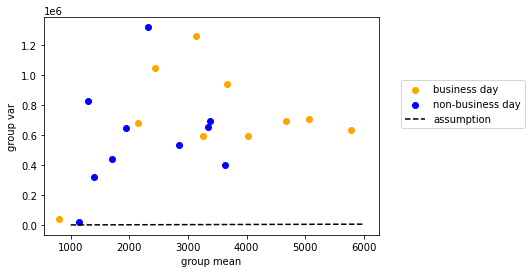

In [20]:
# extraxt data
business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == True]
non_business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == False]

# build "artificial" temperature groups and compute mean and variance in each temperature group

# number of groups
n_groups = 10

# boundaries at which to split data into temperature groups
group_boundaries = np.linspace(np.min(combined_daily_dat['temperature']),np.max(combined_daily_dat['temperature']), n_groups + 1)

# initialize storage for results (means, variances, number of datapoints in group)
means_and_var_results_business_days = np.zeros((n_groups, 4))
means_and_var_results_non_business_days = np.zeros((n_groups, 4))

# compute mean and variance in bike rider counts for each temperature group
for i in np.arange(n_groups):
    
    # extract group data
    # TODO Boundaries nur auf einer Seite reinnehmen
    group_data_business_days = business_day_data[(business_day_data['temperature'] >= group_boundaries[i]) & (business_day_data['temperature'] <= group_boundaries[i+1])]
    group_data_non_business_days = non_business_day_data[(non_business_day_data['temperature'] >= group_boundaries[i]) & (non_business_day_data['temperature'] <= group_boundaries[i+1])]
    
    
    # number of datapoints
    means_and_var_results_business_days[i,3] = group_data_business_days.shape[0]
    means_and_var_results_non_business_days[i,3] = group_data_non_business_days.shape[0]
        
    # if at least one datapoint in business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_business_days[i,0] = group_data_business_days['rider_count'].mean()
        
        # var # TODO sinnvoll bei einem Datenpunkt?
        means_and_var_results_business_days[i,1] = group_data_business_days['rider_count'].var(ddof=1) # TODO ddof?
        
        means_and_var_results_business_days[i,2] = means_and_var_results_business_days[i,1] / means_and_var_results_business_days[i,0] # TODO avoid division by 0

    # if at least one datapoint in non-business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_non_business_days[i,0] = group_data_non_business_days['rider_count'].mean()
        
        # var # TODO sinnvoll bei einem Datenpunkt?
        means_and_var_results_non_business_days[i,1] = group_data_non_business_days['rider_count'].var(ddof=1) # TODO ddof?
        
        means_and_var_results_non_business_days[i,2] = means_and_var_results_non_business_days[i,1] / means_and_var_results_non_business_days[i,0] # TODO avoid division by 0


plt.scatter(means_and_var_results_business_days[:,0], means_and_var_results_business_days[:,1], color='orange', label='business day')
plt.scatter(means_and_var_results_non_business_days[:,0], means_and_var_results_non_business_days[:,1], color='blue', label='non-business day')


# Poisson distribution assumption
plt.plot([1000., 6000.], [1000., 6000.], '--', color='black', label='assumption')

plt.xlabel('group mean')
plt.ylabel('group var')
plt.legend(bbox_to_anchor = (1.45, 0.6), loc='center right');

# print
print('business days:')
print(pd.DataFrame(np.round(means_and_var_results_business_days,2), columns = ['mean','var', 'var/mean', 'n']))
print('non-business days:')
print(pd.DataFrame(np.round(means_and_var_results_non_business_days,2), columns = ['mean','var', 'var/mean', 'n']))

TODO  
means und variances entsprechen sich überhaupt nicht. Also: Annahme für Poisson-Regression nicht erfüllt.

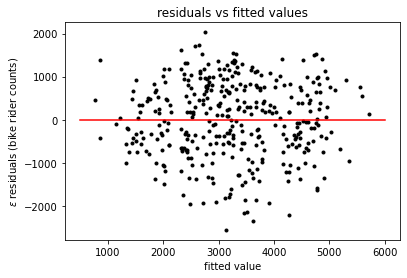

In [21]:
# TODO inspect residuals
plt.plot(fit_daily_counts_poisson_identity.predict(combined_daily_dat), fit_daily_counts_poisson_identity.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('residuals vs fitted values');

For Poisson distribution, the variance in residuals should get larger as the fitted value increases.

#### Bayes

In [22]:
# build linear poisson (TODO wie heißt das jetzt?) model with categories "business-day vs no-business-day"

with pm.Model() as linearPoissonModel:
    
    # TODO prior anpassen
    # TODO Aktuell priors hier etwas anders gesetzt als oben bei Gaussian, um Startbedingungen zu finden,
    # für die der Sampler durchläuft... (kein Problem mit Poisson-Parameter < 0 auftritt)...
    # prior for parameter vector beta
    # TODO Keep in mind: Prior should reflect prior knowledge; not expectation.
    beta_intercept = pm.Normal("beta_intercept", mu=1000, sigma=1000, shape=1)
    beta_slope = pm.Normal("beta_slope", mu=50, sigma=10, shape=1)
    beta_intercept_business_days = pm.Normal("beta_intercept_business_days", mu=0, sigma=1000, shape=1)
    beta_slope_interaction = pm.Normal("beta_slope_interaction", mu=0, sigma=100, shape=1)
    
    # the linear model function
    expected = beta_intercept + beta_slope * combined_daily_dat['temperature'] + beta_intercept_business_days * combined_daily_dat['is_busday'] + beta_slope_interaction * combined_daily_dat['temperature'] * combined_daily_dat['is_busday']
    # TODO hier vielleicht noch sicherstellen, dass es >= 0 ist? Für Poisson...
    
    # Poisson likelihood
    obs = pm.Poisson("observed",
                    mu=expected,
                    observed=combined_daily_dat['rider_count'])
    
# sample
with linearPoissonModel:
    trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_intercept[0],1276.240,6.242,1265.130,1288.432,0.124,0.088,2542.0,3602.0,1.0
beta_slope[0],96.785,0.564,95.772,97.899,0.011,0.008,2610.0,3736.0,1.0
beta_intercept_business_days[0],966.554,8.504,950.353,982.444,0.165,0.117,2644.0,3624.0,1.0
beta_slope_interaction[0],30.688,0.768,29.255,32.131,0.015,0.011,2540.0,3688.0,1.0


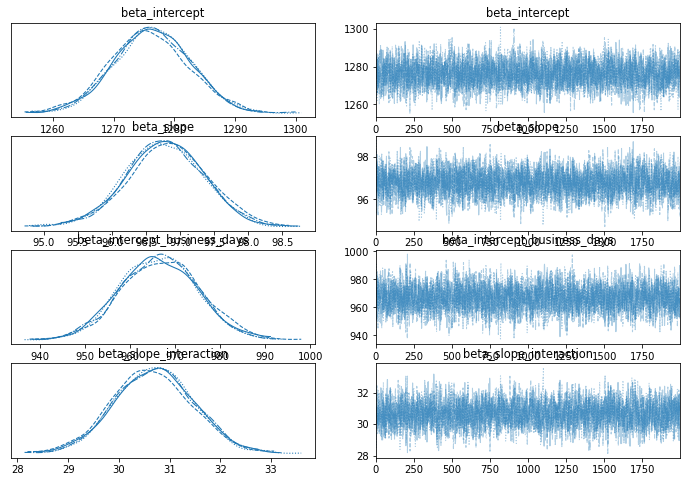

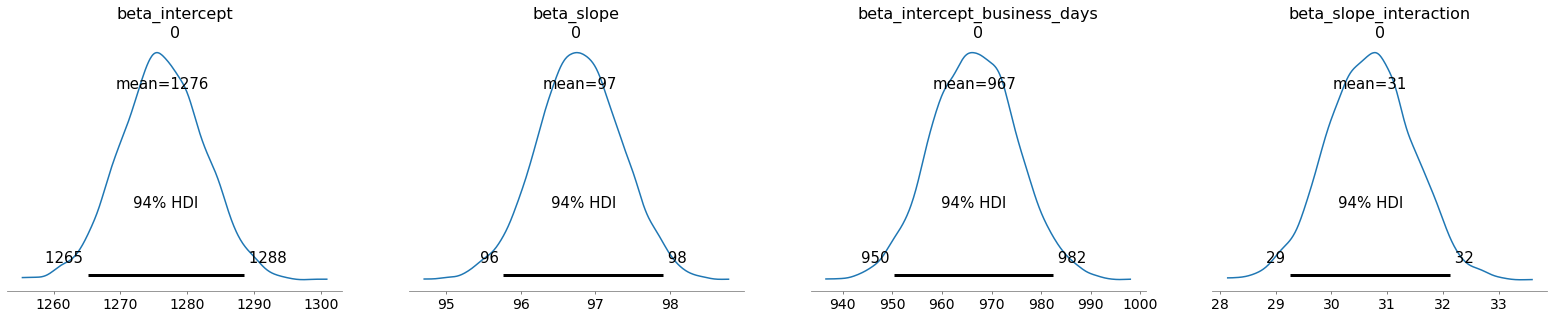

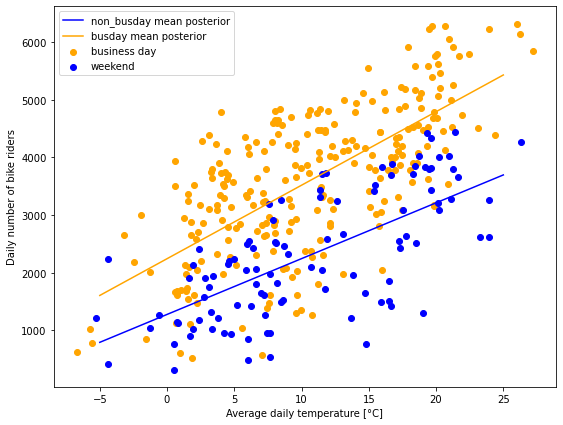

In [23]:
# print / plot the fit results
show_results_linear_fit(linearPoissonModel)

### Bootstrapping

To avoid issues with distribution assumptions.

See also: https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9

In [24]:
# number of simulated experiments/datasets
B = 1000 # TODO increase

# number of samples per dataset
samples_per_dataset = combined_daily_dat.shape[0]

# initialize storage for results
results = np.zeros((B, 4))

# simulate B datasets and fit model to each of them 
for b in np.arange(B):
    
    # simulate dataset
    dat = combined_daily_dat.sample(n=samples_per_dataset, replace=True, axis=0)
    
    # fit model
    bootstrap_fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=dat).fit()
    
    # extract parameters and store them
    results[b, 0] = bootstrap_fit_daily_counts_ols.params['Intercept']
    results[b, 1] = bootstrap_fit_daily_counts_ols.params['temperature']
    results[b, 2] = bootstrap_fit_daily_counts_ols.params['is_busday[T.True]']
    results[b, 3] = bootstrap_fit_daily_counts_ols.params['temperature:is_busday[T.True]']

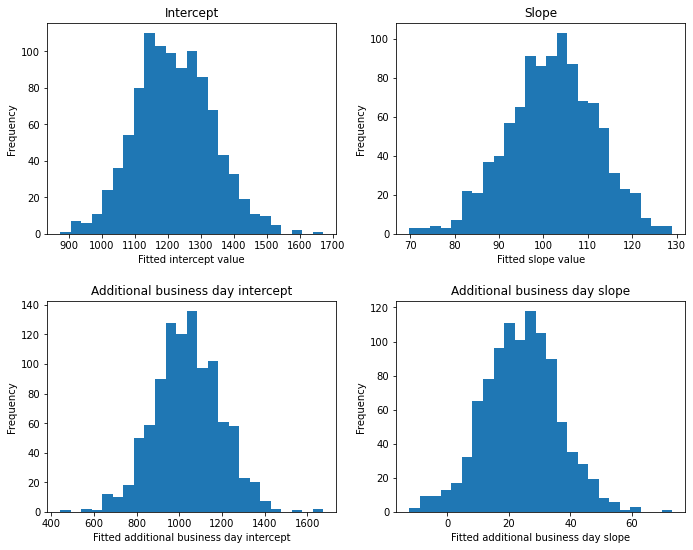

In [25]:
# plot bootstrapped results # TODO Wie nennt man das?

f = plt.figure(figsize=(10,8))

nbins=25

# intercept
ax = f.add_subplot(221)
ax.hist(results[:, 0], bins=nbins)
plt.xlabel('Fitted intercept value')
plt.ylabel('Frequency')
plt.title('Intercept');

# slope
ax = f.add_subplot(222)
ax.hist(results[:, 1], bins=nbins)
plt.xlabel('Fitted slope value')
plt.ylabel('Frequency')
plt.title('Slope');

# additional business day intercept
ax = f.add_subplot(223)
ax.hist(results[:, 2], bins=nbins)
plt.xlabel('Fitted additional business day intercept')
plt.ylabel('Frequency')
plt.title('Additional business day intercept');

# additional business day slope
ax = f.add_subplot(224)
ax.hist(results[:, 3], bins=nbins)
plt.xlabel('Fitted additional business day slope')
plt.ylabel('Frequency')
plt.title('Additional business day slope')

f.tight_layout(pad=2);

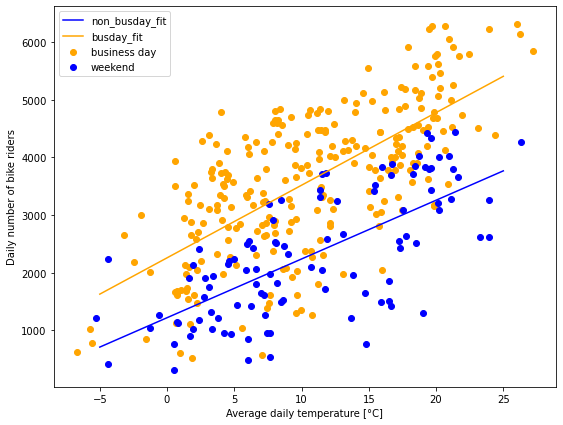

In [26]:
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    results[:, 0].mean(),
    results[:, 1].mean(),
    results[:, 2].mean(),
    results[:, 3].mean()
)

# TODO Stimmt das, dass die means unsere estimates sind?
# TODO Oder vergleicht man ersten Fit an Daten mit Bootstrap-Verteilung?

---
TODO  
Notes:

Possible shortcomings of our analyis method / model:  

- linear model: maybe yields predictions < 0 (--> we assume that this is not an issue for our "region of interest" (i.e., from -5°C to 25°C))
- Normal distribution? --> maybe yields predictions that are not integers.
- Poisson for count data would be good. But: Assumption is violated: Mean $\neq$ Variance

To think about:  
Sind unsere Datenpunkte unabhängig voneinander? Wenn ich Fahrrad schonmal in Keller gebracht habe (für Winter), hole ich es vielleicht auch nicht mehr raus, auch wenn es nochmal wärmer werden sollte...